# 0.0 IMPORTS

In [201]:
import math
import datetime
import inflection
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.core.display  import HTML
from IPython.display       import Image
from boruta                import BorutaPy
from scipy                 import stats as ss
from matplotlib            import pyplot as plt

from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


### 0.1 Helper Functions

In [91]:

def cramer_v ( x,y ):
    cm= pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr= k - (k-1)**2 / (n-1)
    rcorr= r - (r-1)**2 / (n-1)
    
        
    return np.sqrt( ( chi2corr/n ) / ( min( kcorr-1, rcorr-1 ) ) )
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
 

In [92]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\vande\anaconda3\envs\ds-em-producao\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on = 'Store')

# 1.0. PASSO 1 - DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old =[ 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x : inflection.underscore( x )
cols_new = list( map( snakecase,cols_old ) )

#rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [8]:
df1['date']=pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
df1['competition_distance'].max()

75860.0

In [11]:
# competition_distance    
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month 
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)

# competition_open_since_year  
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)
                  
# promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'],axis=1)

# promo2_since_year            
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'],axis=1)

# promo_interval 
month_map = {  1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec' }

df1['promo_interval'].fillna( 0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1)


## 1.6 Change Types

In [12]:
# df1.dtypes

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype("int64")
df1['promo2_since_week'] = df1['promo2_since_week'].astype("int64")
df1['promo2_since_year'] = df1['promo2_since_year'].astype("int64")


## 1.7 Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

## 1.7.1 Numerical attributes

In [15]:
# Central Tendency -  media e mediana - são metricas de tendência central (central tendency)
ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply(np.median)).T

# Dispersion - desvio padrão, variância, range. min, max, skew, curtosis  - são metricas de dispersão
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() -  x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew() ) ).T
d6= pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis() ) ).T
                  
#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','Kurtosis',]

In [16]:
m

,attributes,min,max,range,mean,median,std,skew,Kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


## 1.7.2 Categorical Attributes

In [17]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

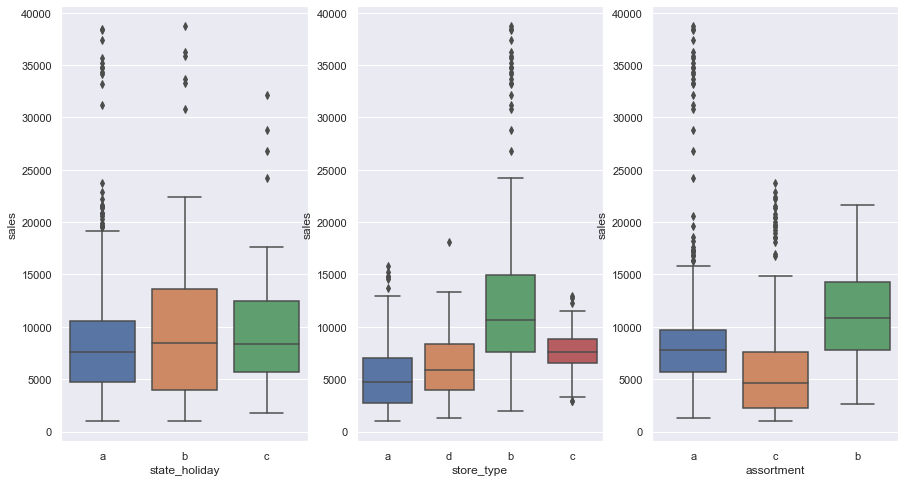

In [18]:

aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday' , y='sales' ,data=aux1 )

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type' , y='sales' ,data=aux1 )

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment' , y='sales' ,data=aux1 )

# 2.0. PASSO 2 - FEATURE ENGINEERING

In [19]:
df2= df1.copy()

## 2.1 Mapa mental de Hipóteses

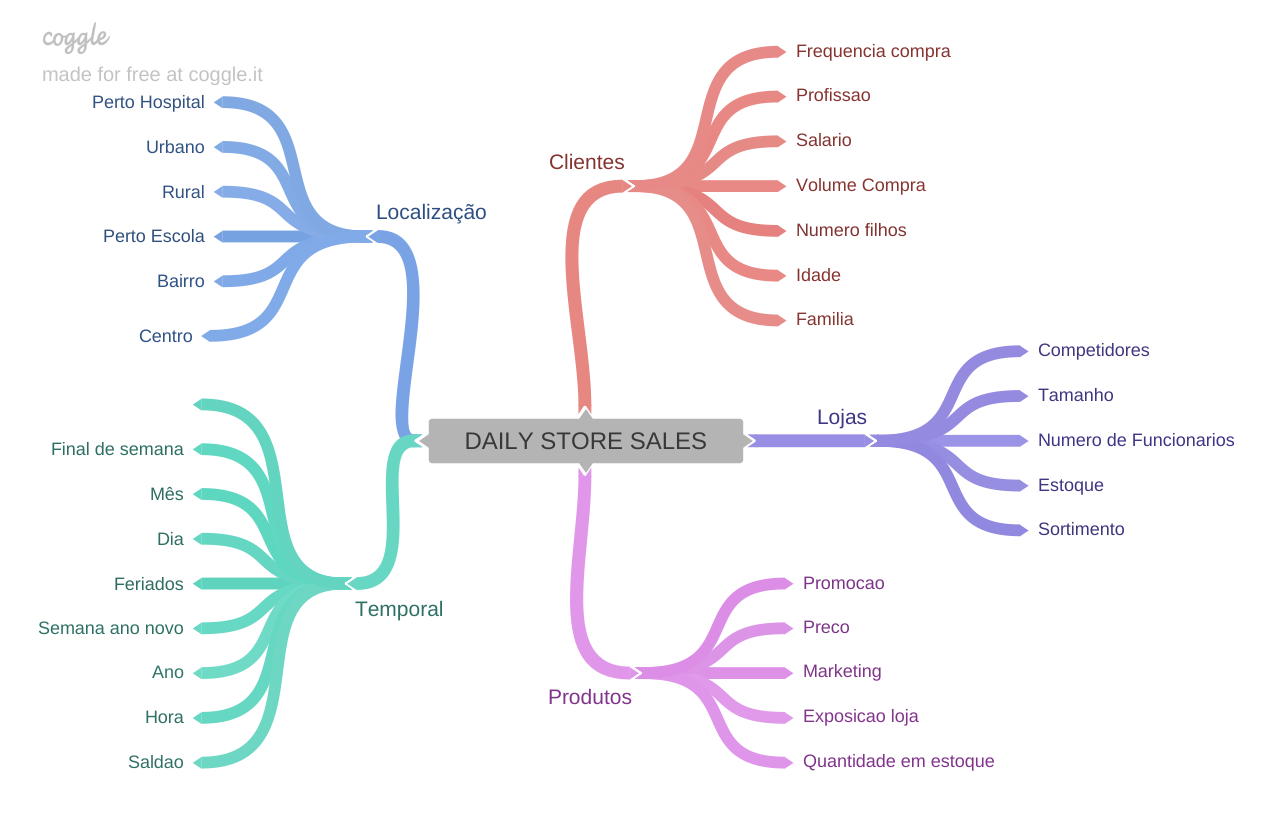

In [20]:
Image('img\MindMapHypotesis.png')

## 2.2 Criaçao das Hipóteses

### 2.1.1. Hipoteses Lojas

**1** Lojas com maior número de funcionários deveriam vender mais.

**2** Lojas com maior capacidade de estique deveriam vender mais.

**3** Lojas com maior porte deveriam vender mais.

**4** Lojas com maior sortimento deveriam vender mais.

**5** Lojas com competidores mais próximos deveriam vender menos.

**6** Lojas com maior competidores a mais tempo deveriam vender mais.

### 2.1.2. Hipoteses Produtos

**1** Lojas que investem mais em marketing deveriam vender mais.

**2** Lojas com exposição de produto deveriam vender mais.

**3** Lojas com produtos com menor preço deveriam vender mais.

**4** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6** Lojas com mais dias de promoção deveriam vender mais.

**7** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Hipoteses Tempo

**1** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2** Lojas deveriam vender mais ao longo dos anos.

**3** Lojas deveriam vender mais no segundo semestre do ano.

**4** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6** Lojas deveriam vender menos aos finais de semana.

**7** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista Final de Hipósteses

**1** Lojas com maior sortimento deveriam vender mais.

**2** Lojas com competidores mais próximos deveriam vender menos.

**3** Lojas com maior competidores a mais tempo deveriam vender mais.

**4** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5** Lojas com mais dias de promoção deveriam vender mais.

**6** Lojas com mais promoções consecutivas deveriam vender mais.

**7** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8** Lojas deveriam vender mais ao longo dos anos.

**9** Lojas deveriam vender mais no segundo semestre do ano.

**10** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11** Lojas com promoções ativas por mais tempo deveriam vender mais.

**12** Lojas deveriam vender menos aos finais de semana.

**13** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [21]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear


# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'] , month= x['competition_open_since_month'], day= 1 ), axis=1 )

df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ))

df2['promo_time_week'] =  ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assorment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x== 'b' else 'christmas' if x =='c' else 'regular_day')

C:\Users\vande\AppData\Local\Temp\ipykernel_26232\542461104.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0. PASSO 3 - FILTRAGEM DE VARIÁVEIS

In [22]:
df3=df2.copy()

In [23]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [24]:
df3 = df3[(df3['open']!= 0) & (df3['sales'] > 0)]

## 3.2. Seleção da colunas

In [25]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

In [26]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [27]:
df3.sample(5)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
642400,946,2,2013-12-03,5967,1,regular_day,0,a,basic,2220.0,12,2011,1,14,2015,0,2013,12,3,49,2013-48,2011-12-01,24,2015-03-30,-69
205213,54,3,2015-01-28,8303,1,regular_day,0,d,extended,7170.0,8,2014,1,5,2013,0,2015,1,28,5,2015-04,2014-08-01,6,2013-01-28,104
82339,945,2,2015-05-19,4470,1,regular_day,0,a,extended,12480.0,3,2011,0,21,2015,0,2015,5,19,21,2015-20,2011-03-01,51,2015-05-18,0
295418,166,3,2014-10-29,3719,0,regular_day,0,a,extended,100.0,4,2014,1,31,2013,1,2014,10,29,44,2014-43,2014-04-01,7,2013-07-29,65
884686,162,1,2013-04-29,8270,1,regular_day,0,d,extended,5340.0,3,2012,1,13,2010,1,2013,4,29,18,2013-17,2012-03-01,14,2010-03-22,162


# 4.0. PASSO 4 - ANÁLISE EXPLORATÓRIA DE DADOS

In [28]:
df4 = df3.copy()

## 4.1 Análise Univariada 

### 4.1.1 Response variable

C:\Users\vande\anaconda3\envs\ds-em-producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

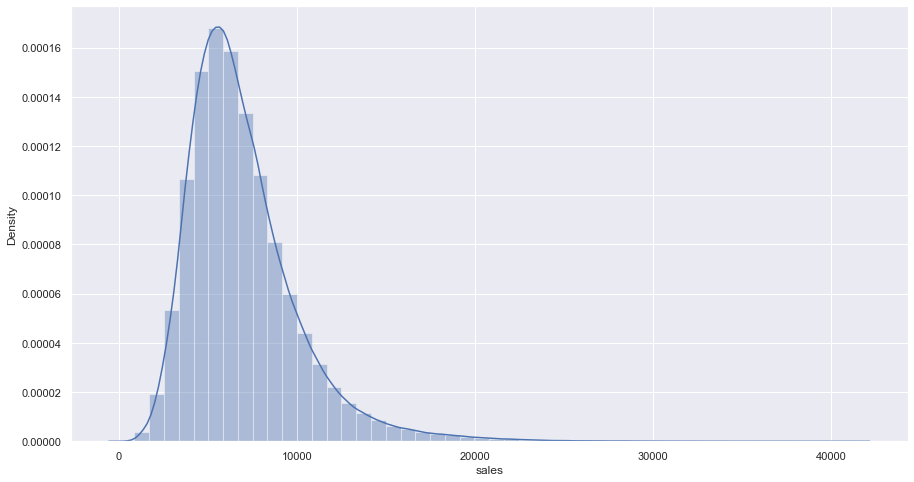

In [29]:
sns.distplot(df4['sales'])

### 4.1.2 Numerical  variable

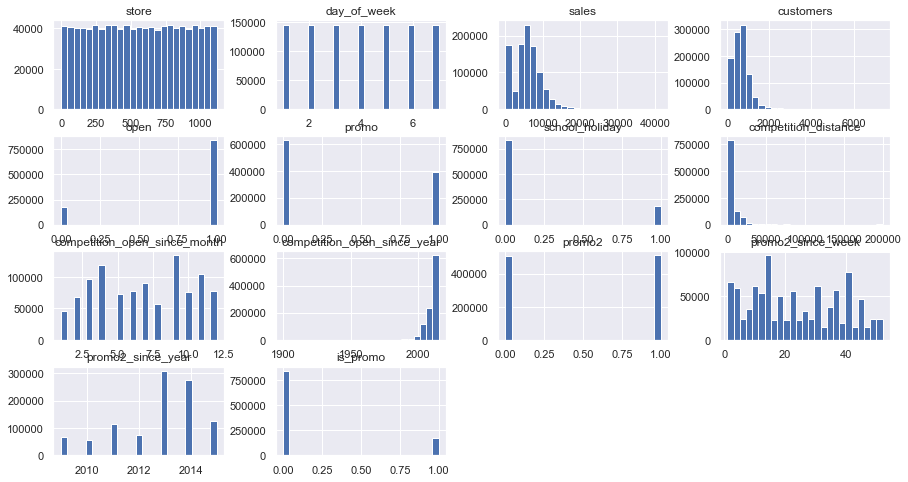

In [149]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical variable

In [31]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

C:\Users\vande\anaconda3\envs\ds-em-producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vande\anaconda3\envs\ds-em-producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vande\anaconda3\envs\ds-em-producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

<AxesSubplot:xlabel='sales', ylabel='Density'>

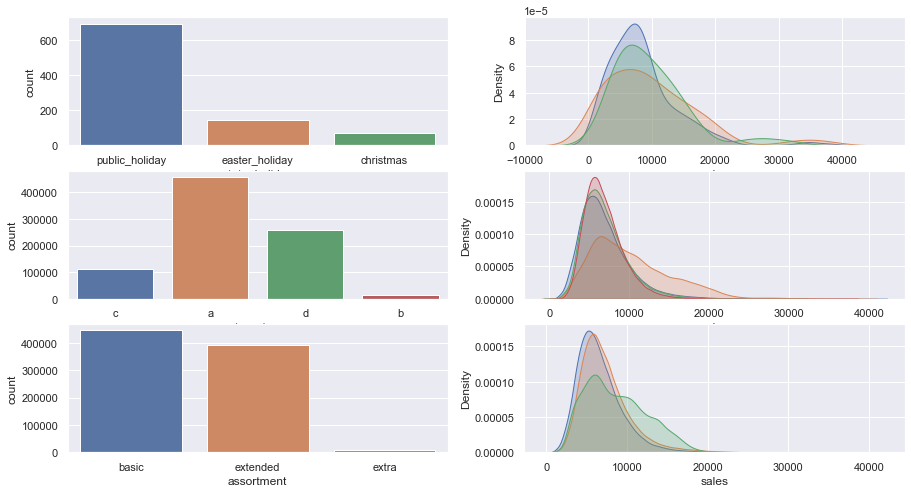

In [32]:
#state_holiday
plt.subplot(3,2,1) # linha, coluna, pos. graf
a= df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2) # linha, coluna, pos. graf
sns.kdeplot(df4[ df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[ df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[ df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)


#store_type
plt.subplot(3,2,3) # linha, coluna, pos. graf
sns.countplot(df4['store_type'])

plt.subplot(3,2,4) # linha, coluna, pos. graf
sns.kdeplot(df4[ df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[ df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[ df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[ df4['store_type'] == 'd']['sales'], label='d', shade=True)


#assorment

plt.subplot(3,2,5) # linha, coluna, pos. graf
sns.countplot(df4['assortment'])

plt.subplot(3,2,6) # linha, coluna, pos. graf
sns.kdeplot(df4[ df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[ df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[ df4['assortment'] == 'extra']['sales'], label='extra', shade=True)


## 4.2 Análise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais.
**VERDADEIRA** Lojas com SORTIMENTO MAIOR vendem MAIS, porém se olharmos o valor total de vendas as lojas com sortimento basis e extended são a grande maioria pelo número de lojas com cada tipo de sortimento.


<AxesSubplot:xlabel='year_week'>

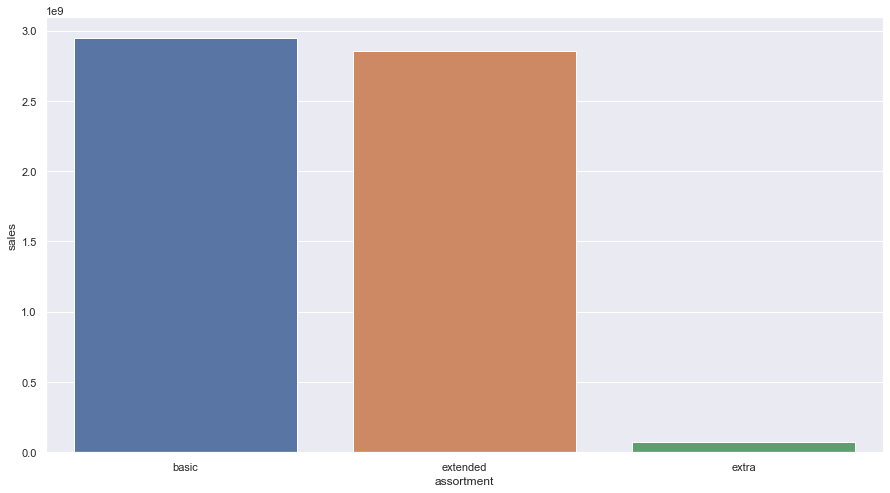

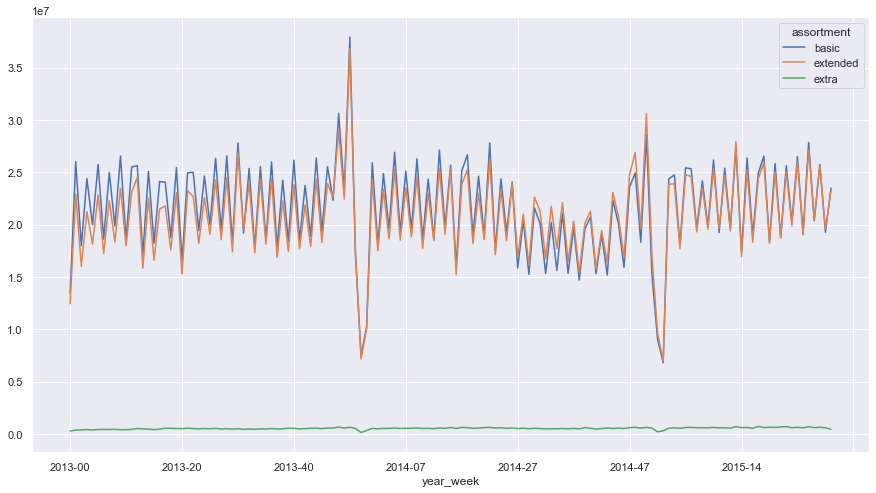

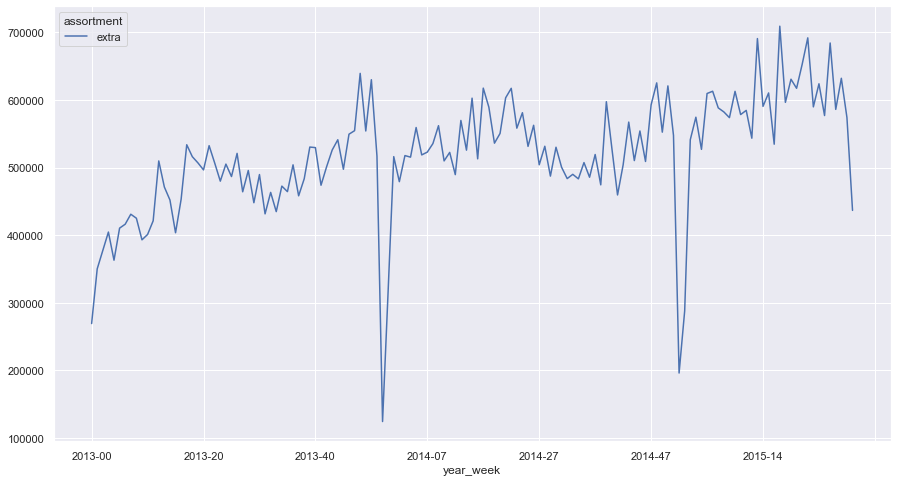

In [82]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot( x= 'assortment' , y= 'sales' , data= aux1 );

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot(index='year_week' , columns='assortment' , values='sales' ).plot()
# sns.barplot( x= 'year_week' , y= 'sales' , data= aux3 );
aux3 = aux2[aux2['assortment'] =='extra']
aux3.pivot(index='year_week' , columns='assortment' , values='sales' ).plot()

,assortment,sales
0,basic,6621.523057
1,extended,7300.843547
2,extra,8642.503594


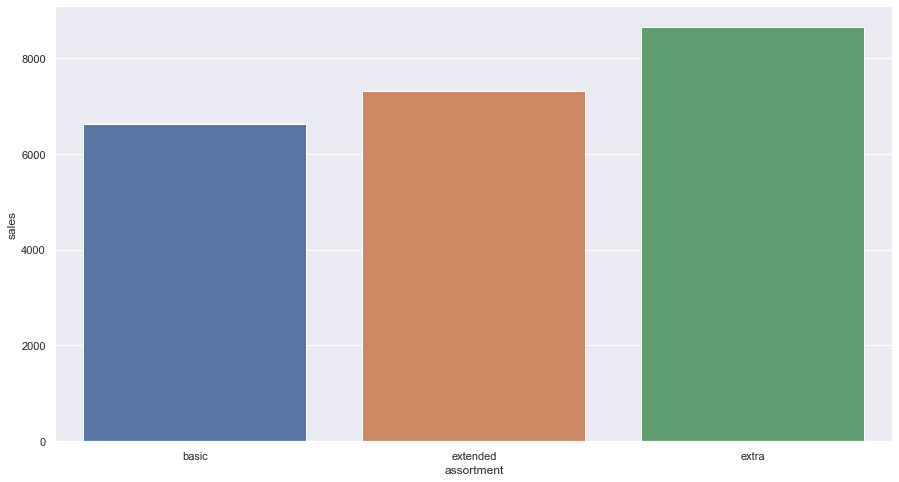

In [80]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales',data=aux1)
aux1

### **H2** Lojas com competidores mais próximos deveriam vender menos.
**FALSA**  Lojas com competidores mais próximos vendem mais

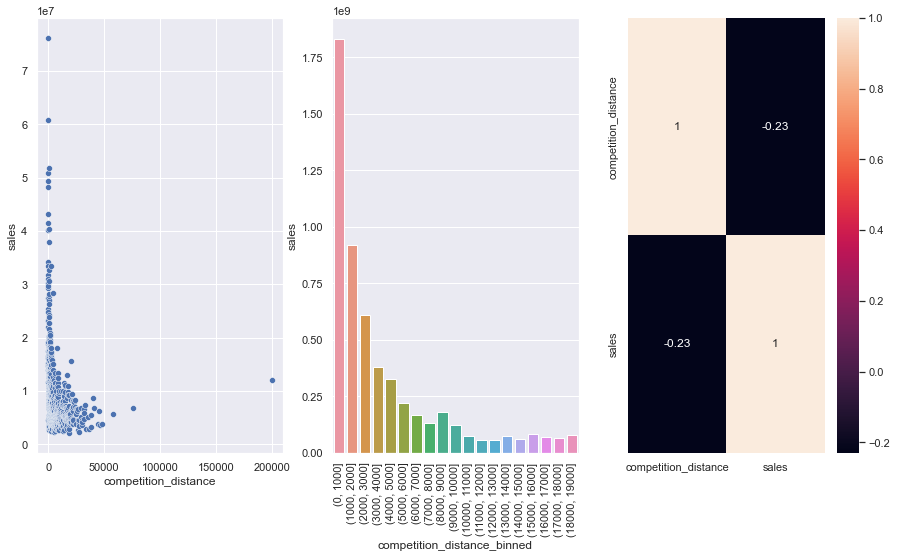

In [86]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x= 'competition_distance' , y='sales', data= aux1 )

plt.subplot(1, 3, 2)
bins = list( np.arange(0, 20000, 1000))
aux1['competition_distance_binned']  = pd.cut( aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x= 'competition_distance_binned' , y='sales' , data=aux2 )
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method = 'pearson' ),annot=True)


### **H3** Lojas com maior competidores a mais tempo deveriam vender mais.
**FALSA** Lojas com COMPETIDORES a MAIS TEMPO vendem MENOS

<AxesSubplot:>

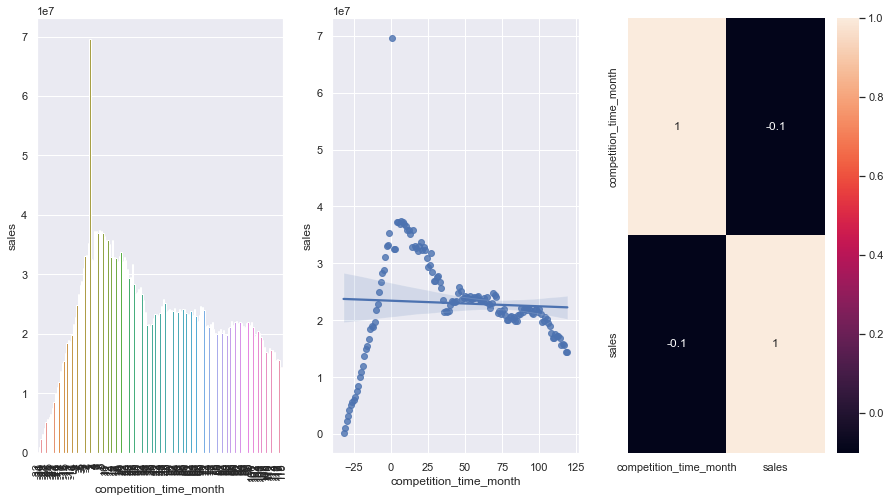

In [35]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

plt.subplot(1, 3, 1)
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


### H4 Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Pois lojas com promoções ativas por mais tempo vendem menos, depois de uma certo tempo.

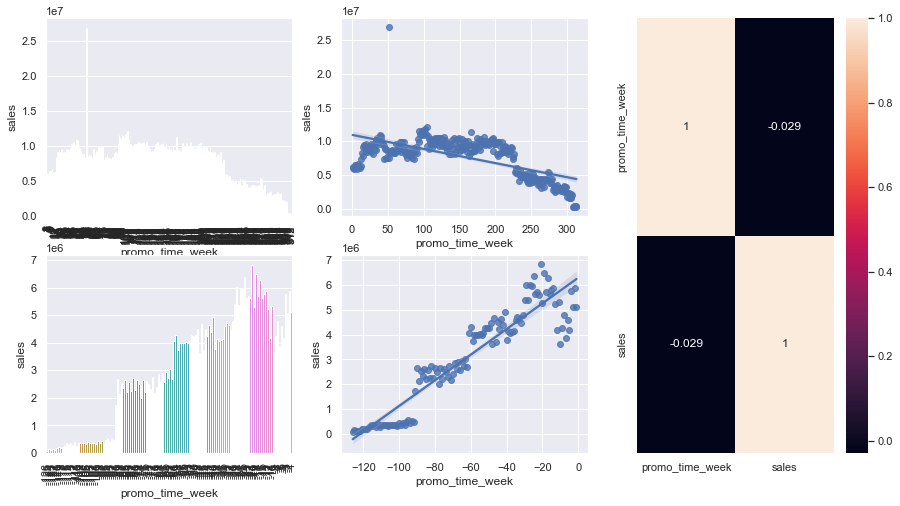

In [36]:
aux1= df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
sns.barplot(x='promo_time_week' , y= 'sales' , data= aux1)

grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # periodo normal de promoção
sns.barplot(x='promo_time_week', y='sales', data= aux2)
plt.xticks(rotation=90);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # periodo extendido de promoção
sns.barplot(x='promo_time_week', y='sales', data= aux3)

plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data= aux2)

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data= aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr( method='pearson'), annot= True);



### <s>H5 Lojas com mais dias de promoção deveriam vender mais.</s>

### H6 Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com promoções consecutivas vendem menos.


In [37]:
df4[['promo','promo2','sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


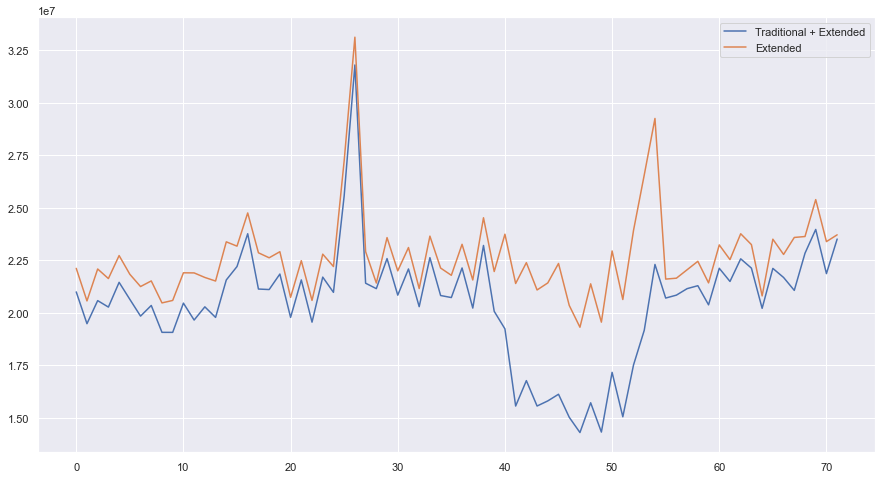

In [38]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Traditional + Extended', 'Extended']);


### **H7** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas não vendem mais durante o feriado de Natal, em comparação com os outros feriados.

<AxesSubplot:xlabel='year', ylabel='sales'>

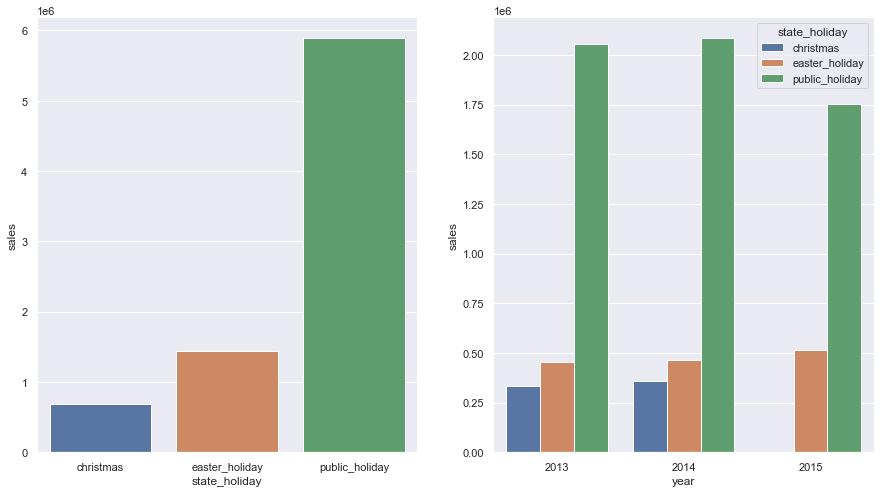

In [39]:
plt.subplot(1, 2, 1)
aux = df4[df4['state_holiday'] !='regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday' ,y='sales' ,data= aux1)

plt.subplot(1, 2, 2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year' ,y='sales', hue='state_holiday', data=aux2 )

### **H8** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas estão vendendo menos ao longo dos anos

<AxesSubplot:>

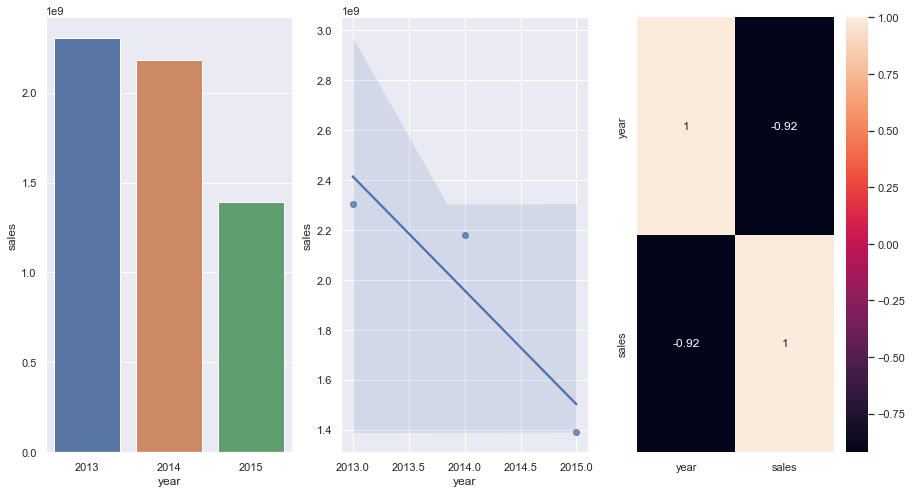

In [40]:
plt.subplot(1,3,1)
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H9** Lojas deveriam vender mais no segundo semestre do ano.

**VERDADEIRA** Removendo a ano de 2015, pode ver que as lojas vendem mais no segundo semestre.

<AxesSubplot:>

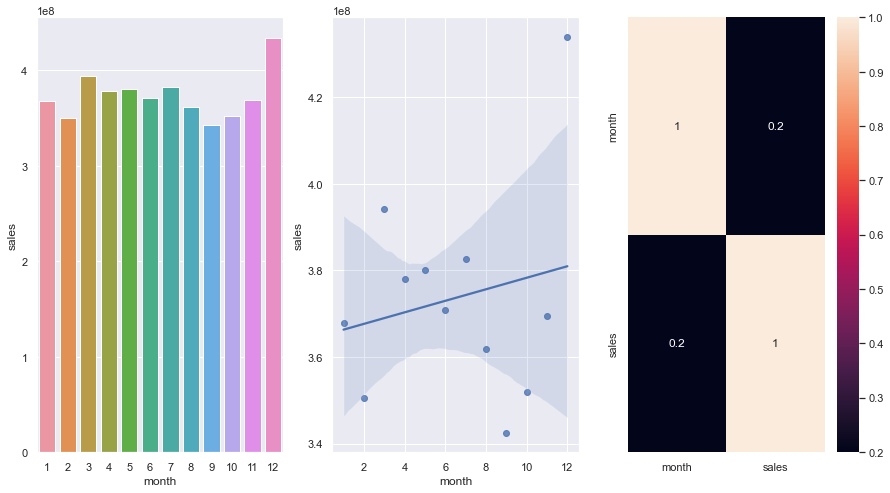

In [41]:
plt.subplot(1,3,1)
aux = df4[df4['year'] < 2015]
aux1 = aux[['month','sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H10** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês

<AxesSubplot:xlabel='before_after', ylabel='sales'>

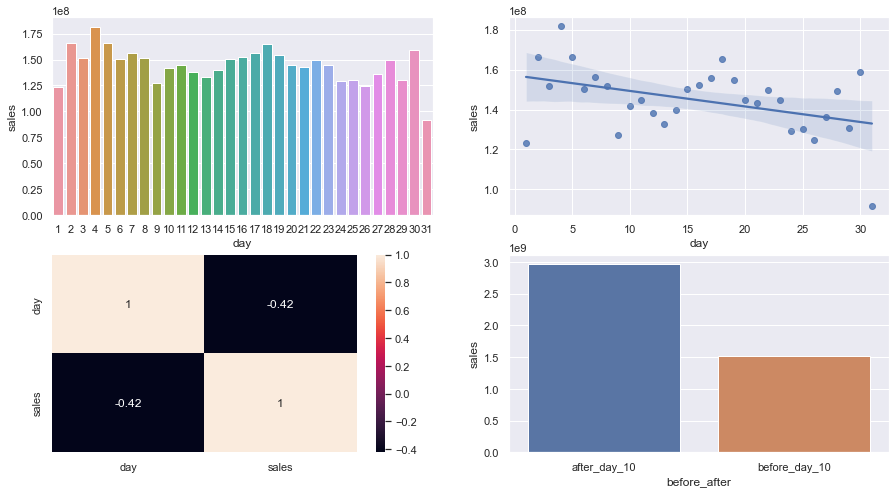

In [42]:
plt.subplot(2,2,1)
aux1 = aux[['day','sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_day_10'if x <= 10 else 'after_day_10')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data = aux2)



### **H11** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA**Lojas vendem menos nos finais de semana

<AxesSubplot:>

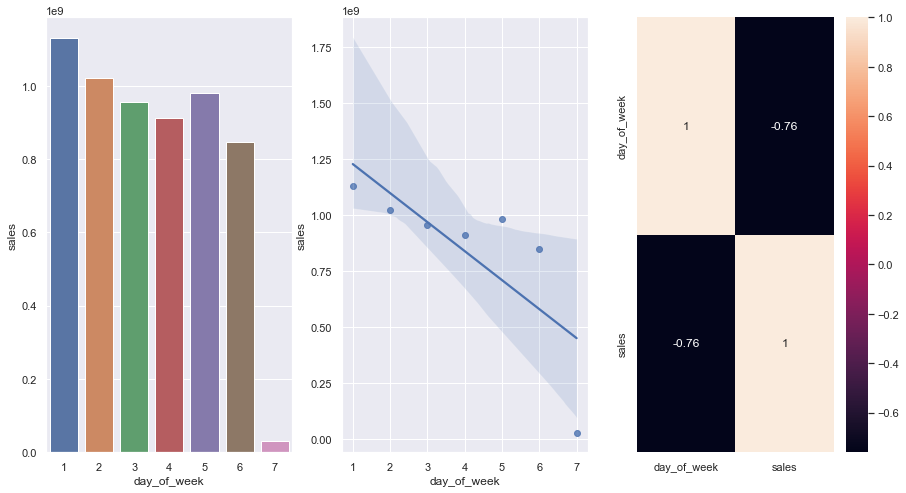

In [43]:
plt.subplot(1,3,1)
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H12 Lojas deveriam vender menos durante os feriados escolares
**VERDADEIRA** Lojas vendem menos em todos os meses do ano, exceto julho e agosto

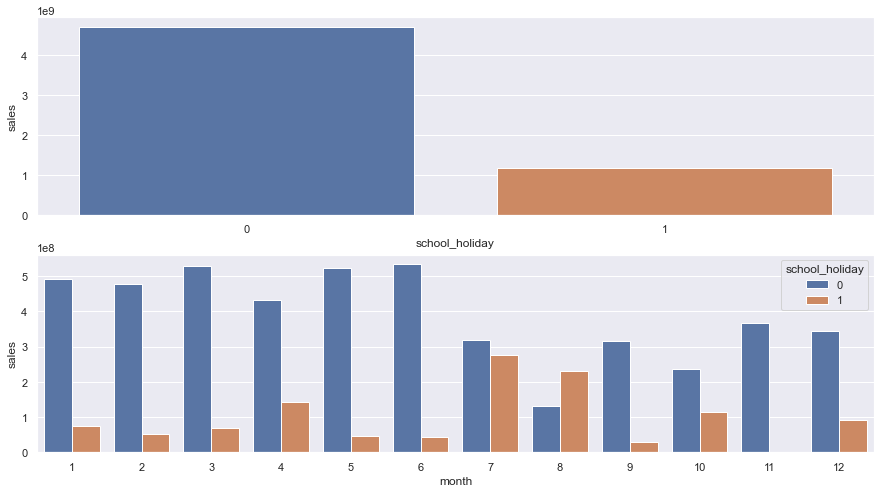

In [44]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2,1,2)
aux1 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales',hue= 'school_holiday', data=aux1);


## 4.1 Análise Multivariada

### 4.3.1 Numerical atributes

<AxesSubplot:>

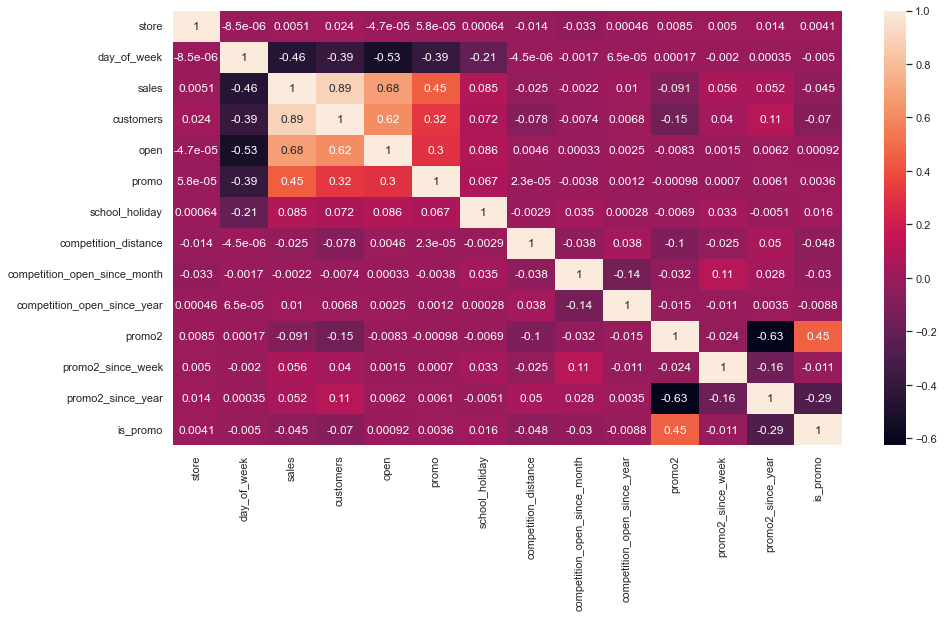

In [93]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot = True)

### 4.3.2 Categorical atributes

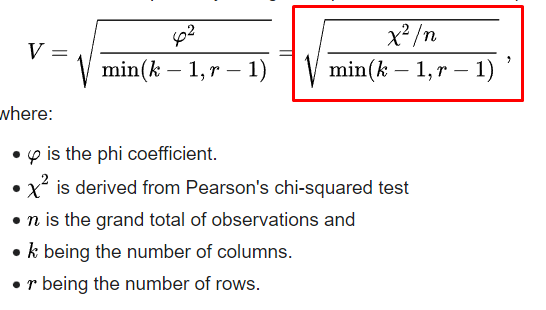

In [98]:
Image('img\cramerv.png')

<AxesSubplot:>

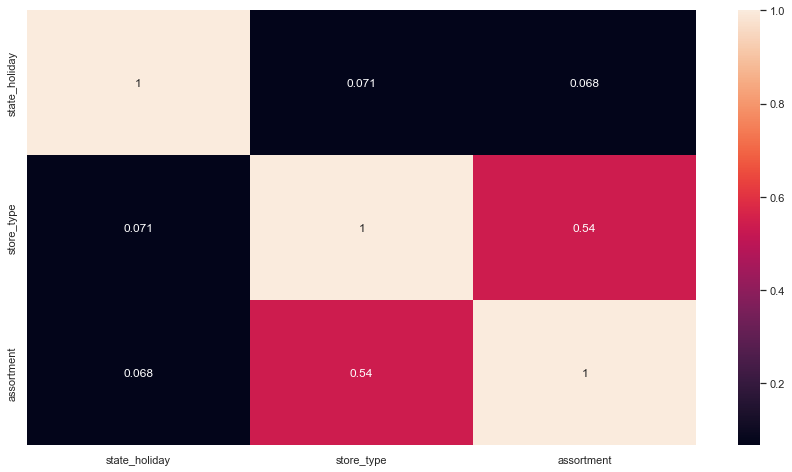

In [148]:
#getting only categorical data
a = df4.select_dtypes( include ='object')

#calculate cramer's v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame({'state_holiday':[a1, a2, a3],
              'store_type':[a4, a5, a6],
              'assortment':[a7, a8, a9]  })

d = d.set_index(d.columns)
sns.heatmap(d, annot = True)

# 5.0. PASSO 5 - DATA PREPARATION

In [152]:
df5 = df4.copy()

## 5.1. Normalização

**Ao analisar as variáveis, vimos que nao temos nenhuma distribuição normal que possamos normalizar, então vamops seguir para o Rescaling**

## 5.2. Rescaling

In [153]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values )

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )

# Promo time week 
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform(df5[['year']].values )


## 5.3. Transformação

### 5.3.1 Encoding

In [171]:
# state_holiday - One Hot Encoding 
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assort_dict = {'basic':1 , 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assort_dict)

KeyError: "None of [Index(['state_holiday'], dtype='object')] are in the [columns]"

### 5.3.2 Response variable transformation

In [175]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transformation

In [176]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x *  ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x *  ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. *  np.pi/52 ) ) )

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. *  np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. *  np.pi/7 ) ) )


# 6.0. PASSO 6 - FEATURE SELECTION -  BORUTA

In [183]:
df6 = df5.copy()

## 6.1 Split Dataframe into traning and test dataset

In [184]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis=1)

In [190]:
df6[['store','date']].groupby(['store']).max().reset_index()['date'][0] - datetime.timedelta(days= 6*7)

Timestamp('2015-06-19 00:00:00')

In [198]:
# training dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

#test dateset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_train['sales']

print('Training Min date {}'.format(x_train['date'].min() ) )
print('Training Max date {}'.format(x_train['date'].max() ) )

print('\nTest Min date {}'.format(x_test['date'].min() ) )
print('Test Max date {}'.format(x_test['date'].max() ) )

Training Min date 2013-01-01 00:00:00
Training Max date 2015-06-18 00:00:00

Test Min date 2015-06-19 00:00:00
Test Max date 2015-07-31 00:00:00


## 6.2 Boruta as feature selection

In [203]:
# training and test dataset for boruta
x_train_n = x_train.drop(['date','sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

# define Random Forest
rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1 Best features from Boruta

In [207]:
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = x_train.drop( ['date','sales'], axis = 1 )
cols_selected_boruta = x_train_fs.iloc[: , cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

## 6.3 Manual feature selection

In [210]:
cols_selected_boruta = [
        'store',
        'promo',
        'store_type',
        'assortment',
        'competition_distance',
        'competition_open_since_month',
        'competition_open_since_year',
        'promo2',
        'promo2_since_week',
        'promo2_since_year',
        'competition_time_month',
        'promo_time_week',
        'month_cos',
        'month_sin',
        'day_sin',
        'day_cos',
        'week_of_year_sin'
        'week_of_year_cos',
        'day_of_week_sin',
        'day_of_week_cos']

# columns to add
feat_to_add = ['date','sales']

# final features
cols_selected_boruta.extend( feat_to_add )

In [212]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_sinweek_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'date',
 'sales']